# Tourist satisfaction with transport systems to Mount Etna, Sicily. Part 1. NLP.

# This cell will prompt you to connect this notebook with your google account.
from google.colab import drive                                                                        
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'Academy/+ Papers/en_proceso/mount_etna/'


In [1]:
base_dir = '/mnt/g/My Drive/Academy/+ Papers/en_proceso/mount_etna/' # To run locally

# 1. Data pre-processing

In [2]:
#!pip install pycaret[full]

## Importing libraries

In [3]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
import spacy
#spacy.load("en_core_web_sm")


# NLTK
import string
import nltk
from nltk import word_tokenize
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('words')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet, stopwords
from collections import Counter
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer

#ignore log(0) and divide by 0 warning
np.seterr(divide = 'ignore');
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

print('Libraries read!')

Libraries read!


[nltk_data] Downloading package stopwords to /home/juan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/juan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/juan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /home/juan/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/juan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Reading data

In [4]:
data = pd.read_csv(base_dir + 'data/mount_etna_data.csv')
data = data[['author', 'title', 'content', 'rating']]

# Dropping rows without data in content
data = data.dropna(subset = ['content']).reset_index(drop=True)
# Dropping rows with "cable" in the content.
data = data[data["content"].str.contains("cable")==False].reset_index(drop=True)

print('Data shape: ', data.shape)
data.head()

Data shape:  (2097, 4)


author                                              title  \
0  Michele Amico🇮🇹🇮🇹🇮🇹🇮🇹                                             Etna🇮🇹   
1      elizabethlascheid  You must see an active volcano at least once i...   
2  Michele Amico🇮🇹🇮🇹🇮🇹🇮🇹                                     Wonderful Etna   
3  Michele Amico🇮🇹🇮🇹🇮🇹🇮🇹                                             Etna🇮🇹   
4           Freedom27060                                 loved every minute   

                                             content  rating  
0  East side of the sicilian island, in the Catan...       5  
1  Mount Etna is extraordinary. It is an active v...       5  
2  It's always a great and sensational emotion to...       5  
3  This is a today picture of the Etna Volcano. W...       5  
4  Last month, September 2005, we (two couples fr...       5

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2097 entries, 0 to 2096
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   author   2095 non-null   object
 1   title    2097 non-null   object
 2   content  2097 non-null   object
 3   rating   2097 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 65.7+ KB


# Filtering comments using EACH keyword, to assess imbalance in dataset

In [6]:
TRANSPORT_KEYWORD = ['car']


for i in TRANSPORT_KEYWORD:
    # Filtering
    data_filtered = data.copy()
    data_filtered['is_transport_related'] = data_filtered['content'].str.contains(i, case=False, na=False)
    data_filtered = data_filtered[data_filtered['is_transport_related']==True].reset_index(drop=True)
    data_filtered = data_filtered.drop(columns=['is_transport_related'])

    # Creating sentiment_rating feature based on rating
    data_filtered['sentiment_rating'] = np.where(data_filtered['rating'] > 3,1,0)
    #TODO dejar solo 1 y 2 para negativo para tratar de mejorar metricas

    # changing bad and good just for visualization in the recall metric
    data_filtered['sentiment_rating'] = data_filtered['sentiment_rating'].replace([0,1],['negative', 'positive'])
    data_filtered['sentiment_rating'] = data_filtered['sentiment_rating'].replace(['negative','positive'],[1, 0]) # NEGATIVE IS 1!!!!



    # Printing datasets    
    print('Dataset using keyword: {}.'.format(i))
    print('Data shape: ', data_filtered.shape)
    print(data_filtered['sentiment_rating'].value_counts(normalize=True))
    display(data_filtered.head(10))
    print('--------------')

Dataset using keyword: car.
Data shape:  (353, 5)
0    0.932011
1    0.067989
Name: sentiment_rating, dtype: float64


author                                              title  \
0  elizabethlascheid  You must see an active volcano at least once i...   
1   Inspiration10420                               Day Trip to Mt. Etna   
2          gregspeck                    Cable car and a hike to Mt Etna   
3            Kathy R  Memorable day in Etna & Taormina with Sicily Life   
4            Josie M                      Here’s what you need to know!   
5             nshugg                   MY FAVORITE SICILIAN EXPERIENCE!   
6            Cathy E                     National Park - Full of Trash!   
7      familyfun5280  Sicilylife cruise excursion tour of Mt. Etna a...   
8            briskit       Choose a good tour company if you visit Etna   
9        Tiggero5501                             Really Cool Experience   

                                             content  rating  sentiment_rating  
0  Mount Etna is extraordinary. It is an active v...       5                 0  
1  This was our second visit to Sicily and we imm...       5                 0  
2  Cable car ride to mid mountain  is 29 Euro. Fr...       5                 0  
3  Kudos to Sicily Life for providing my group of...       5                 0  
4  Drive up to the Refugio and get there early - ...       5                 0  
5  If driving rent a GPS.  You're life will be mu...       5                 0  
6  You can see Mount Etna from a distance.  That ...       1                 1  
7  My family and I used SicilyLife during our sta...       4                 0  
8  Be careful to choose Etna Sicily Touring compa...       5                 0  
9  Although pricey (30 Euros to ride the funicula...       4                 0

--------------


## Filtering comments according to keywords

In [7]:
# TRANSPORT_KEYWORDS = 'transport|rail|cable|car|bus|transportation|mobility|bike'
TRANSPORT_KEYWORDS = 'car'

In [8]:
# Filtering
data['is_transport_related'] = data['content'].str.contains(TRANSPORT_KEYWORDS, case=False, na=False)
data = data[data['is_transport_related']==True].reset_index(drop=True)
data = data.drop(columns=['is_transport_related'])

# New dataset
print('Data shape: ', data.shape)
data.head(10)

Data shape:  (353, 4)


author                                              title  \
0  elizabethlascheid  You must see an active volcano at least once i...   
1   Inspiration10420                               Day Trip to Mt. Etna   
2          gregspeck                    Cable car and a hike to Mt Etna   
3            Kathy R  Memorable day in Etna & Taormina with Sicily Life   
4            Josie M                      Here’s what you need to know!   
5             nshugg                   MY FAVORITE SICILIAN EXPERIENCE!   
6            Cathy E                     National Park - Full of Trash!   
7      familyfun5280  Sicilylife cruise excursion tour of Mt. Etna a...   
8            briskit       Choose a good tour company if you visit Etna   
9        Tiggero5501                             Really Cool Experience   

                                             content  rating  
0  Mount Etna is extraordinary. It is an active v...       5  
1  This was our second visit to Sicily and we imm...       5  
2  Cable car ride to mid mountain  is 29 Euro. Fr...       5  
3  Kudos to Sicily Life for providing my group of...       5  
4  Drive up to the Refugio and get there early - ...       5  
5  If driving rent a GPS.  You're life will be mu...       5  
6  You can see Mount Etna from a distance.  That ...       1  
7  My family and I used SicilyLife during our sta...       4  
8  Be careful to choose Etna Sicily Touring compa...       5  
9  Although pricey (30 Euros to ride the funicula...       4

In [9]:
# Creating sentiment_rating feature based on rating
data['sentiment_rating'] = np.where(data['rating'] > 3,1,0)
#TODO dejar solo 1 y 2 para negativo para tratar de mejorar metricas

# changing bad and good just for visualization in the recall metric
data['sentiment_rating'] = data['sentiment_rating'].replace([0,1],['negative', 'positive'])
data['sentiment_rating'] = data['sentiment_rating'].replace(['negative','positive'],[1, 0]) # NEGATIVE IS 1!!!!

In [10]:
data['sentiment_rating'].value_counts(normalize=True)

0    0.932011
1    0.067989
Name: sentiment_rating, dtype: float64

#### This data is imbalanced, as 90% of the reviews are positive (4, 5) and just 10% are negative (1, 2, 3)

9072


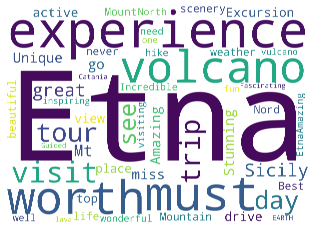

In [11]:
# Wordcloud of title

word_cloud_text = ''.join(data['title'])
print(len(word_cloud_text))
wordcloud = WordCloud(max_font_size=500, 
                      max_words=50,
                      background_color="white",
                      scale=10,
                      width=1000, 
                      height=720).generate(word_cloud_text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(0,0.3)
plt.savefig(base_dir + 'output/car/title_wordcloud.png', dpi=400,  bbox_inches='tight')
plt.show();

227667


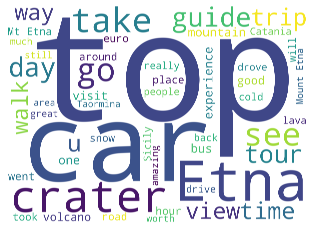

In [12]:
# Wordcloud of content

word_cloud_text = ''.join(data['content'])
print(len(word_cloud_text))
wordcloud = WordCloud(max_font_size=500, 
                      max_words=50,
                      background_color="white",
                      scale=10,
                      width=1000, 
                      height=720).generate(word_cloud_text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(0,0.3)
plt.savefig(base_dir + 'output/car/content_wordcloud.png', dpi=400,  bbox_inches='tight')
plt.show();

# 3. NLP for title

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 353 entries, 0 to 352
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   author            353 non-null    object
 1   title             353 non-null    object
 2   content           353 non-null    object
 3   rating            353 non-null    int64 
 4   sentiment_rating  353 non-null    int64 
dtypes: int64(2), object(3)
memory usage: 13.9+ KB


In [14]:
stopwords_corpus = nltk.corpus.stopwords
eng_stop_words = stopwords_corpus.words('english')

In [15]:
noise_words_title = []
token_lists_title = [word_tokenize(each) for each in data['title']]
tokens_title = [item for sublist in token_lists_title for item in sublist]
print("Number of unique tokens then: ",len(set(tokens_title)))


Number of unique tokens then:  641


In [16]:
one_percentile_title = int(len(set(tokens_title)) * 0.01)
top_1_percentile_title = Counter(tokens_title).most_common(one_percentile_title)
bottom_1_percentile_title = Counter(tokens_title).most_common()[-one_percentile_title:]

print(top_1_percentile_title[:10])
print('---------------')
print(bottom_1_percentile_title[:10])

[('!', 72), ('Etna', 53), ('the', 52), ('to', 48), ('a', 42), ('of', 37)]
---------------
[('short', 1), ("'re", 1), ('Glad', 1), ('Had', 1), ('Rocks', 1), ('rock', 1)]


In [17]:
noise_words_title.extend(eng_stop_words)
noise_words_title.extend([word for word, val in top_1_percentile_title])
noise_words_title.extend([word for word, val in bottom_1_percentile_title])

In [18]:
data

author                                              title  \
0    elizabethlascheid  You must see an active volcano at least once i...   
1     Inspiration10420                               Day Trip to Mt. Etna   
2            gregspeck                    Cable car and a hike to Mt Etna   
3              Kathy R  Memorable day in Etna & Taormina with Sicily Life   
4              Josie M                      Here’s what you need to know!   
..                 ...                                                ...   
348           Henrik E                                  Excursion to Etna   
349        BahiaDelray                                       Magnificent!   
350  LaidbackTravelers                    An Experience We're Glad We Had   
351             SORF01              Fascinating day out if you have a car   
352        DianaMary60                                        Rocks rock!   

                                               content  rating  \
0    Mount Etna is extraordinary. It is an active v...       5   
1    This was our second visit to Sicily and we imm...       5   
2    Cable car ride to mid mountain  is 29 Euro. Fr...       5   
3    Kudos to Sicily Life for providing my group of...       5   
4    Drive up to the Refugio and get there early - ...       5   
..                                                 ...     ...   
348  We joined a guided trip including a 2 hrs stop...       5   
349  We flew from Naples to Catania and then travel...       5   
350  We booked a trip to Sicily (Taoramina) just be...       5   
351  We weren't expecting snow in April but there w...       4   
352  I went in a 4-wheel drive car, in company with...       5   

     sentiment_rating  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0  
..                ...  
348                 0  
349                 0  
350                 0  
351                 0  
352                 0  

[353 rows x 5 columns]

In [19]:
# Pycaret
from pycaret.nlp import *

exp_name = setup(data = data[['title', 'sentiment_rating']],  
                 target = 'title',
                 session_id = 42,
                 custom_stopwords = noise_words_title
                )

In [20]:
lda_title = create_model('lda', multi_core = True) # Latent Dirichlet Allocation
print('Latent Dirichlet Allocation: ', lda_title)
lda_title_data = assign_model(lda_title)

In [21]:
print('Shape of lda_title_data: ', lda_title_data.shape)
display(lda_title_data.head())
print('------')
lda_title_data.describe(include='all')

Shape of lda_title_data:  (353, 8)


title  sentiment_rating   Topic_0   Topic_1  \
0  must see active volcano least life                 0  0.579021  0.036498   
1                            day trip                 0  0.413265  0.087282   
2                      cable car hike                 0  0.062550  0.810345   
3                           memorable                 0  0.125241  0.125209   
4                           need know                 0  0.741014  0.083426   

    Topic_2   Topic_3 Dominant_Topic  Perc_Dominant_Topic  
0  0.348511  0.035970        Topic 0                 0.58  
1  0.088372  0.411081        Topic 0                 0.41  
2  0.064552  0.062552        Topic 1                 0.81  
3  0.624329  0.125221        Topic 2                 0.62  
4  0.083431  0.092129        Topic 0                 0.74

------


title  sentiment_rating     Topic_0     Topic_1     Topic_2  \
count    353        353.000000  353.000000  353.000000  353.000000   
unique   256               NaN         NaN         NaN         NaN   
top                        NaN         NaN         NaN         NaN   
freq      52               NaN         NaN         NaN         NaN   
mean     NaN          0.067989    0.225835    0.253155    0.286211   
std      NaN          0.252084    0.237382    0.256687    0.273623   
min      NaN          0.000000    0.031375    0.035757    0.031832   
25%      NaN          0.000000    0.083350    0.083357    0.083399   
50%      NaN          0.000000    0.125016    0.125044    0.125151   
75%      NaN          0.000000    0.250000    0.250000    0.550496   
max      NaN          1.000000    0.877743    0.905340    0.872984   

           Topic_3 Dominant_Topic  Perc_Dominant_Topic  
count   353.000000            353           353.000000  
unique         NaN              4                  NaN  
top            NaN        Topic 0                  NaN  
freq           NaN            116                  NaN  
mean      0.234799            NaN             0.640822  
std       0.246673            NaN             0.192960  
min       0.031453            NaN             0.250000  
25%       0.083371            NaN             0.610000  
50%       0.125066            NaN             0.730000  
75%       0.250000            NaN             0.790000  
max       0.884895            NaN             0.910000

## Tuning number of topics

In [22]:
tuned_lda_title = tune_model(model = 'lda', 
                             multi_core = True, 
                             supervised_target = 'sentiment_rating',
                             custom_grid = [2,3,4],
                             optimize = 'AUC'
                             )

IntProgress(value=0, description='Processing: ', max=13)

Output()

Best Model: Latent Dirichlet Allocation | # Topics: 3 | AUC : 0.6027


In [23]:
lda_title_tuned = create_model('lda', multi_core = True, num_topics=tuned_lda_title.num_topics) # Latent Dirichlet Allocation
print('Latent Dirichlet Allocation: ', lda_title_tuned)
lda_title_data_tuned = assign_model(lda_title_tuned)
lda_title_data_tuned = lda_title_data_tuned.add_prefix('Title_')
lda_title_data_tuned['Title_Dominant_Topic'] = lda_title_data_tuned['Title_Dominant_Topic'].replace(' ', '_', regex=True)

In [24]:
print('Shape of lda_title_data_tuned: ', lda_title_data_tuned.shape)
display(lda_title_data_tuned.head())
print('------')
lda_title_data_tuned.describe(include='all')

Shape of lda_title_data_tuned:  (353, 7)


Title_title  Title_sentiment_rating  Title_Topic_0  \
0  must see active volcano least life                       0       0.789744   
1                            day trip                       0       0.440206   
2                      cable car hike                       0       0.083693   
3                           memorable                       0       0.168423   
4                           need know                       0       0.745830   

   Title_Topic_1  Title_Topic_2 Title_Dominant_Topic  \
0       0.049322       0.160934              Topic_0   
1       0.130630       0.429163              Topic_0   
2       0.826061       0.090245              Topic_1   
3       0.168492       0.663085              Topic_2   
4       0.112028       0.142142              Topic_0   

   Title_Perc_Dominant_Topic  
0                       0.79  
1                       0.44  
2                       0.83  
3                       0.66  
4                       0.75

------


Title_title  Title_sentiment_rating  Title_Topic_0  Title_Topic_1  \
count          353              353.000000     353.000000     353.000000   
unique         256                     NaN            NaN            NaN   
top                                    NaN            NaN            NaN   
freq            52                     NaN            NaN            NaN   
mean           NaN                0.067989       0.311877       0.306237   
std            NaN                0.252084       0.262684       0.255202   
min            NaN                0.000000       0.045301       0.049322   
25%            NaN                0.000000       0.111615       0.111748   
50%            NaN                0.000000       0.168400       0.168479   
75%            NaN                0.000000       0.482927       0.391517   
max            NaN                1.000000       0.886132       0.903179   

        Title_Topic_2 Title_Dominant_Topic  Title_Perc_Dominant_Topic  
count      353.000000                  353                 353.000000  
unique            NaN                    3                        NaN  
top               NaN              Topic_0                        NaN  
freq              NaN                  143                        NaN  
mean         0.381886                  NaN                   0.671473  
std          0.286069                  NaN                   0.170972  
min          0.047848                  NaN                   0.330000  
25%          0.112307                  NaN                   0.620000  
50%          0.333333                  NaN                   0.710000  
75%          0.665873                  NaN                   0.780000  
max          0.899150                  NaN                   0.900000

In [25]:
lda_title_data_tuned

Title_title  Title_sentiment_rating  \
0    must see active volcano least life                       0   
1                              day trip                       0   
2                        cable car hike                       0   
3                             memorable                       0   
4                             need know                       0   
..                                  ...                     ...   
348                           excursion                       0   
349                         magnificent                       0   
350                     experience glad                       0   
351                 fascinating day car                       0   
352                                                           0   

     Title_Topic_0  Title_Topic_1  Title_Topic_2 Title_Dominant_Topic  \
0         0.789744       0.049322       0.160934              Topic_0   
1         0.440206       0.130630       0.429163              Topic_0   
2         0.083693       0.826061       0.090245              Topic_1   
3         0.168423       0.168492       0.663085              Topic_2   
4         0.745830       0.112028       0.142142              Topic_0   
..             ...            ...            ...                  ...   
348       0.666198       0.166930       0.166872              Topic_0   
349       0.664190       0.168080       0.167729              Topic_0   
350       0.111665       0.111873       0.776462              Topic_2   
351       0.083561       0.089464       0.826974              Topic_2   
352       0.333333       0.333333       0.333333              Topic_0   

     Title_Perc_Dominant_Topic  
0                         0.79  
1                         0.44  
2                         0.83  
3                         0.66  
4                         0.75  
..                         ...  
348                       0.67  
349                       0.66  
350                       0.78  
351                       0.83  
352                       0.33  

[353 rows x 7 columns]

## Wordclouds, bigrams and trigrams for Titles

Wordcloud for Title_Topic_0
0    128
1     15
Name: Title_sentiment_rating, dtype: int64


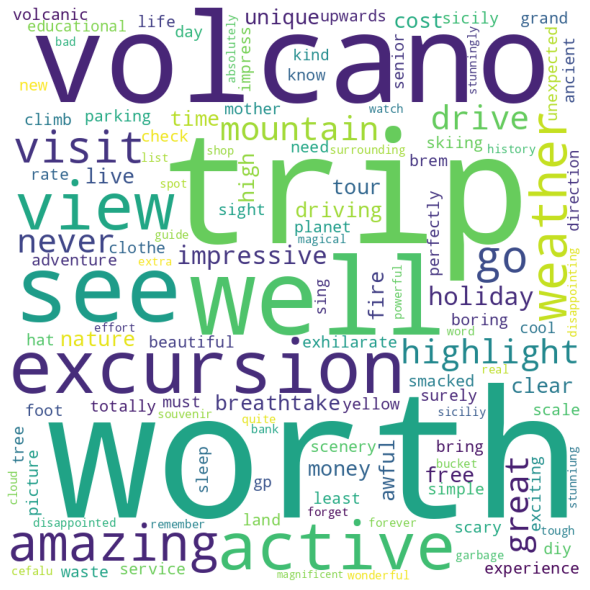

----------------------------------


Wordcloud for Title_Topic_1
0    77
1     5
Name: Title_sentiment_rating, dtype: int64


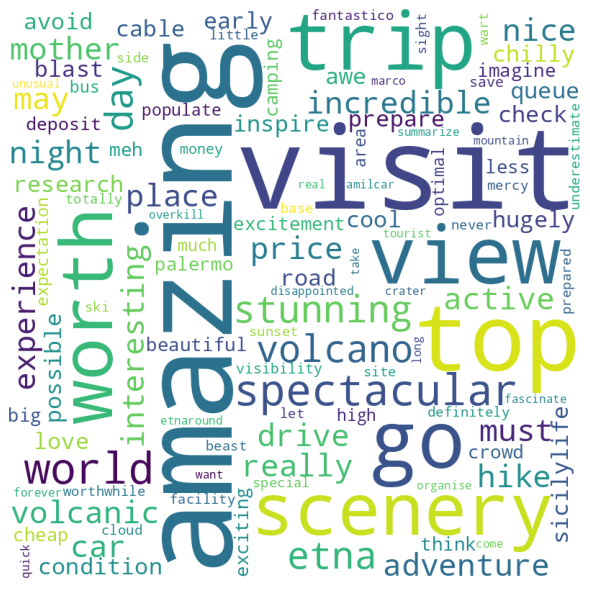

----------------------------------


Wordcloud for Title_Topic_2
0    124
1      4
Name: Title_sentiment_rating, dtype: int64


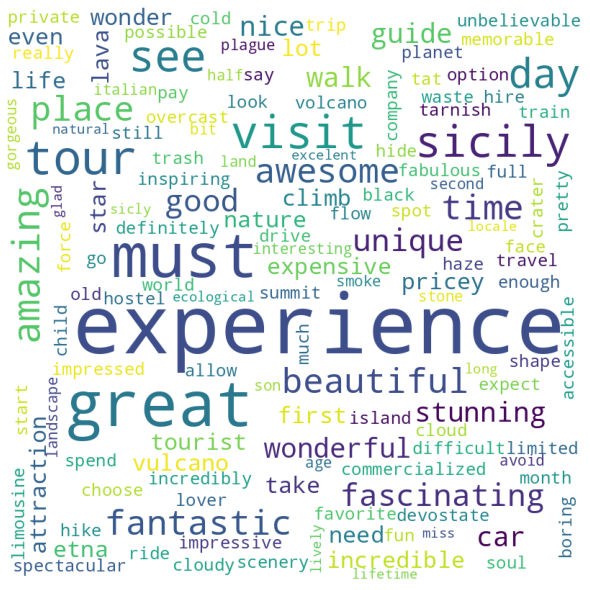

----------------------------------




In [26]:
for i in lda_title_data_tuned.filter(regex='Title_Topic_'):
    print('Wordcloud for {}'.format(i))
    title_topic = lda_title_data_tuned[lda_title_data_tuned['Title_Dominant_Topic']== i[len('Title_'):]]
    print(title_topic['Title_sentiment_rating'].value_counts())
    # WORDCLOUD
    plot_model(lda_title_tuned, plot='wordcloud', topic_num=i[len('Title_'):].replace('_', ' '), 
           #save=True
          )
    # BIGRAMS
    plot_model(lda_title_tuned, plot='bigram', topic_num=i[len('Title_'):].replace('_', ' '))
    # TRIGRAMS
    plot_model(lda_title_tuned, plot='trigram', topic_num=i[len('Title_'):].replace('_', ' '))
    
    print('----------------------------------')
    print('\n')

## Wordclouds, bigrams and trigrams for Titles - SENTIMENT POSITIVE

Wordcloud for Title_Topic_0
0    128
Name: Title_sentiment_rating, dtype: int64


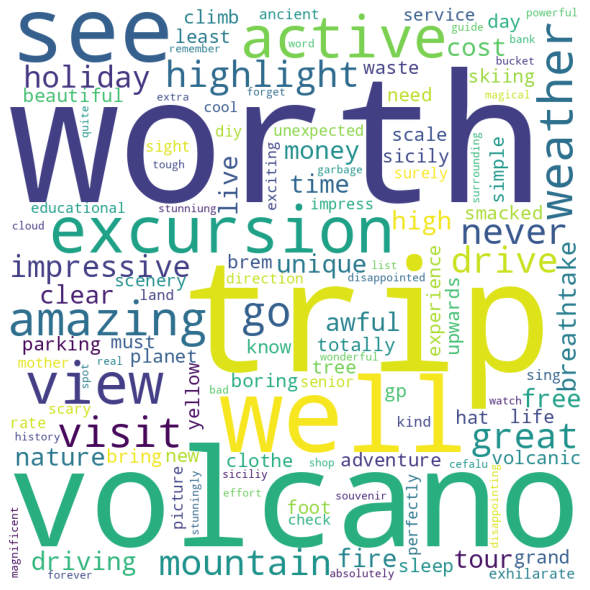

----------------------------------


Wordcloud for Title_Topic_1
0    77
Name: Title_sentiment_rating, dtype: int64


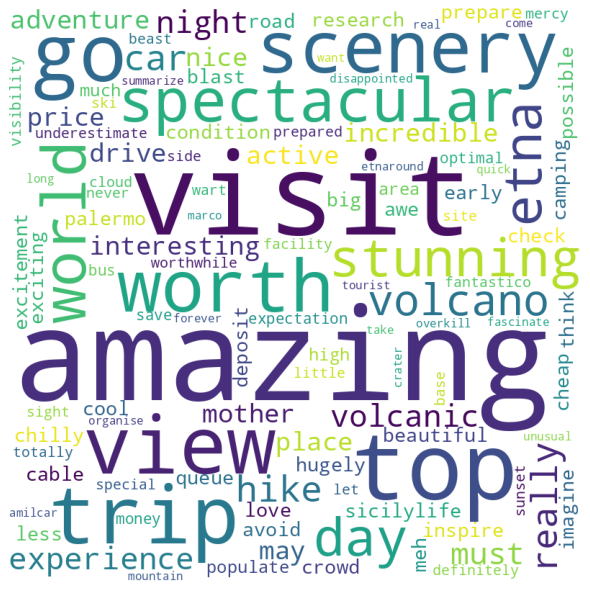

----------------------------------


Wordcloud for Title_Topic_2
0    124
Name: Title_sentiment_rating, dtype: int64


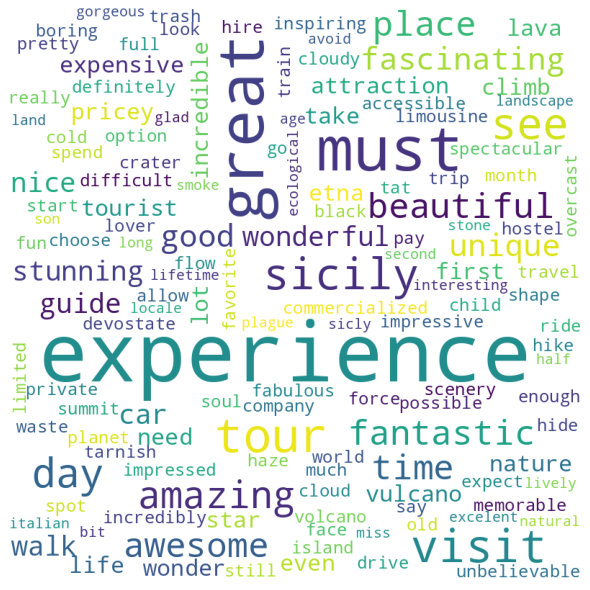

----------------------------------




In [27]:
for i in lda_title_data_tuned.filter(regex='Title_Topic_'):
    print('Wordcloud for {}'.format(i))
    title_topic = lda_title_data_tuned[lda_title_data_tuned['Title_sentiment_rating']== 0]
    title_topic = title_topic[title_topic['Title_Dominant_Topic']== i[len('Title_'):]]
    print(title_topic['Title_sentiment_rating'].value_counts())
    # WORDCLOUD
    plot_model(lda_title_tuned, plot='wordcloud', topic_num=i[len('Title_'):].replace('_', ' '), 
           #save=True
          )
    # BIGRAMS
    plot_model(lda_title_tuned, plot='bigram', topic_num=i[len('Title_'):].replace('_', ' '))
    # TRIGRAMS
    plot_model(lda_title_tuned, plot='trigram', topic_num=i[len('Title_'):].replace('_', ' '))
    
    print('----------------------------------')
    print('\n')

## Wordclouds, bigrams and trigrams for Titles - SENTIMENT NEGATIVE

Wordcloud for Title_Topic_0
1    15
Name: Title_sentiment_rating, dtype: int64


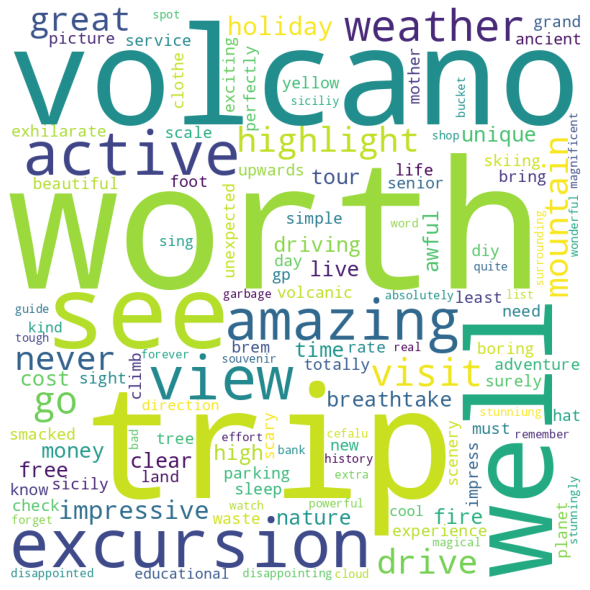

----------------------------------


Wordcloud for Title_Topic_1
1    5
Name: Title_sentiment_rating, dtype: int64


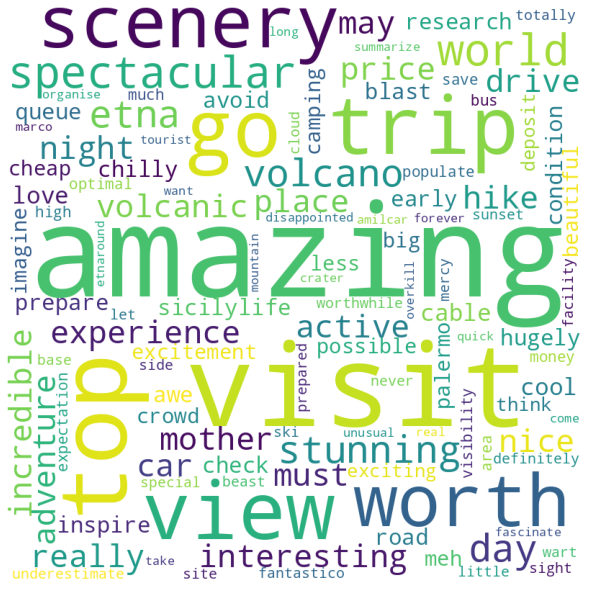

----------------------------------


Wordcloud for Title_Topic_2
1    4
Name: Title_sentiment_rating, dtype: int64


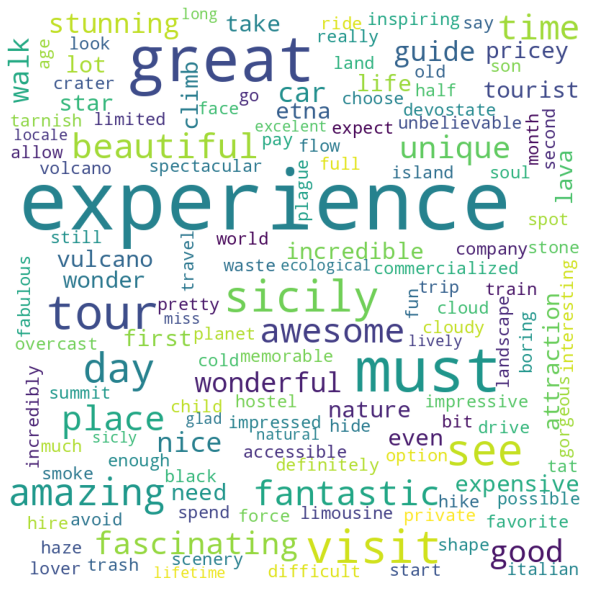

----------------------------------




In [28]:
for i in lda_title_data_tuned.filter(regex='Title_Topic_'):
    print('Wordcloud for {}'.format(i))
    title_topic = lda_title_data_tuned[lda_title_data_tuned['Title_sentiment_rating']== 1]
    title_topic = title_topic[title_topic['Title_Dominant_Topic']== i[len('Title_'):]]
    print(title_topic['Title_sentiment_rating'].value_counts())
    # WORDCLOUD
    plot_model(lda_title_tuned, plot='wordcloud', topic_num=i[len('Title_'):].replace('_', ' '), 
           #save=True
          )
    # BIGRAMS
    plot_model(lda_title_tuned, plot='bigram', topic_num=i[len('Title_'):].replace('_', ' '))
    # TRIGRAMS
    plot_model(lda_title_tuned, plot='trigram', topic_num=i[len('Title_'):].replace('_', ' '))
    
    print('----------------------------------')
    print('\n')

## Evaluation of the model

In [29]:
# Evaluation of the model
evaluate_model(lda_title_tuned)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Frequency Plot', 'freque…

In [30]:
lda_title_data_tuned

Title_title  Title_sentiment_rating  \
0    must see active volcano least life                       0   
1                              day trip                       0   
2                        cable car hike                       0   
3                             memorable                       0   
4                             need know                       0   
..                                  ...                     ...   
348                           excursion                       0   
349                         magnificent                       0   
350                     experience glad                       0   
351                 fascinating day car                       0   
352                                                           0   

     Title_Topic_0  Title_Topic_1  Title_Topic_2 Title_Dominant_Topic  \
0         0.789744       0.049322       0.160934              Topic_0   
1         0.440206       0.130630       0.429163              Topic_0   
2         0.083693       0.826061       0.090245              Topic_1   
3         0.168423       0.168492       0.663085              Topic_2   
4         0.745830       0.112028       0.142142              Topic_0   
..             ...            ...            ...                  ...   
348       0.666198       0.166930       0.166872              Topic_0   
349       0.664190       0.168080       0.167729              Topic_0   
350       0.111665       0.111873       0.776462              Topic_2   
351       0.083561       0.089464       0.826974              Topic_2   
352       0.333333       0.333333       0.333333              Topic_0   

     Title_Perc_Dominant_Topic  
0                         0.79  
1                         0.44  
2                         0.83  
3                         0.66  
4                         0.75  
..                         ...  
348                       0.67  
349                       0.66  
350                       0.78  
351                       0.83  
352                       0.33  

[353 rows x 7 columns]

In [31]:
lda_title_data_tuned.to_csv(base_dir + 'data/car/lda_title_data_tuned.csv', index=False)

In [32]:
save_model(lda_title_tuned, base_dir + 'models/car/model_title_jupyter')

Model Succesfully Saved


(<gensim.models.ldamulticore.LdaMulticore at 0x7fb5ff525e80>,
 '/mnt/g/My Drive/Academy/+ Papers/en_proceso/mount_etna/models/car/model_title_jupyter.pkl')

# 4. NLP for review

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 353 entries, 0 to 352
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   author            353 non-null    object
 1   title             353 non-null    object
 2   content           353 non-null    object
 3   rating            353 non-null    int64 
 4   sentiment_rating  353 non-null    int64 
dtypes: int64(2), object(3)
memory usage: 13.9+ KB


In [34]:
noise_words_review = []
token_lists_review = [word_tokenize(each) for each in data['content']]
tokens_review = [item for sublist in token_lists_review for item in sublist]
print("Number of unique tokens then: ",len(set(tokens_review)))


Number of unique tokens then:  5068


In [35]:
one_percentile_review = int(len(set(tokens_review)) * 0.01)
top_1_percentile_review = Counter(tokens_review).most_common(one_percentile_review)
bottom_1_percentile_review = Counter(tokens_review).most_common()[-one_percentile_review:]

print(top_1_percentile_review[:10])
print('---------------')
print(bottom_1_percentile_review[:10])

[('the', 2504), ('.', 2179), (',', 1731), ('to', 1420), ('and', 1393), ('a', 1204), ('of', 812), ('you', 666), ('was', 585), ('is', 553)]
---------------
[('travels', 1), ('suburbs', 1), ('vegatation', 1), ('terminates', 1), ('regional', 1), ('hidden', 1), ('op', 1), ('tempted', 1), ('Was', 1), ('massive', 1)]


In [36]:
noise_words_review.extend(eng_stop_words)
noise_words_review.extend([word for word, val in top_1_percentile_review])
noise_words_review.extend([word for word, val in bottom_1_percentile_review])

In [37]:
data

author                                              title  \
0    elizabethlascheid  You must see an active volcano at least once i...   
1     Inspiration10420                               Day Trip to Mt. Etna   
2            gregspeck                    Cable car and a hike to Mt Etna   
3              Kathy R  Memorable day in Etna & Taormina with Sicily Life   
4              Josie M                      Here’s what you need to know!   
..                 ...                                                ...   
348           Henrik E                                  Excursion to Etna   
349        BahiaDelray                                       Magnificent!   
350  LaidbackTravelers                    An Experience We're Glad We Had   
351             SORF01              Fascinating day out if you have a car   
352        DianaMary60                                        Rocks rock!   

                                               content  rating  \
0    Mount Etna is extraordinary. It is an active v...       5   
1    This was our second visit to Sicily and we imm...       5   
2    Cable car ride to mid mountain  is 29 Euro. Fr...       5   
3    Kudos to Sicily Life for providing my group of...       5   
4    Drive up to the Refugio and get there early - ...       5   
..                                                 ...     ...   
348  We joined a guided trip including a 2 hrs stop...       5   
349  We flew from Naples to Catania and then travel...       5   
350  We booked a trip to Sicily (Taoramina) just be...       5   
351  We weren't expecting snow in April but there w...       4   
352  I went in a 4-wheel drive car, in company with...       5   

     sentiment_rating  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0  
..                ...  
348                 0  
349                 0  
350                 0  
351                 0  
352                 0  

[353 rows x 5 columns]

In [38]:
# Pycaret
from pycaret.nlp import *

exp_name = setup(data = data[['content', 'sentiment_rating']],  
                 target = 'content',
                 session_id = 42,
                 custom_stopwords = noise_words_review
                )

In [39]:
lda_review = create_model('lda', multi_core = True) # Latent Dirichlet Allocation
print('Latent Dirichlet Allocation: ', lda_review)
lda_review_data = assign_model(lda_review)

In [40]:
print('Shape of lda_review_data: ', lda_review_data.shape)
display(lda_review_data.head())
print('------')
lda_review_data.describe(include='all')

Shape of lda_review_data:  (353, 8)


content  sentiment_rating  \
0  extraordinary active volcano beautiful landsca...                 0   
1  second visit immediately contact sabastiano li...                 0   
2  cable ride catch terrain vehicle know price wa...                 0   
3  life provide group special day touring freedom...                 0   
4  drive early park big lot front restaurant stai...                 0   

    Topic_0   Topic_1   Topic_2   Topic_3 Dominant_Topic  Perc_Dominant_Topic  
0  0.004579  0.004650  0.986160  0.004612        Topic 2                 0.99  
1  0.003768  0.003817  0.988569  0.003846        Topic 2                 0.99  
2  0.007965  0.008016  0.007975  0.976044        Topic 3                 0.98  
3  0.001290  0.001296  0.001330  0.996085        Topic 3                 1.00  
4  0.002783  0.991629  0.002772  0.002816        Topic 1                 0.99

------


content  sentiment_rating  \
count                                                 353        353.000000   
unique                                                353               NaN   
top     extraordinary active volcano beautiful landsca...               NaN   
freq                                                    1               NaN   
mean                                                  NaN          0.067989   
std                                                   NaN          0.252084   
min                                                   NaN          0.000000   
25%                                                   NaN          0.000000   
50%                                                   NaN          0.000000   
75%                                                   NaN          0.000000   
max                                                   NaN          1.000000   

           Topic_0     Topic_1     Topic_2     Topic_3 Dominant_Topic  \
count   353.000000  353.000000  353.000000  353.000000            353   
unique         NaN         NaN         NaN         NaN              4   
top            NaN         NaN         NaN         NaN        Topic 3   
freq           NaN         NaN         NaN         NaN            119   
mean      0.192125    0.230087    0.242771    0.335017            NaN   
std       0.359078    0.386866    0.396063    0.431404            NaN   
min       0.001029    0.001052    0.001043    0.001586            NaN   
25%       0.005097    0.005403    0.005496    0.005998            NaN   
50%       0.009472    0.010127    0.011051    0.013874            NaN   
75%       0.028987    0.281676    0.396477    0.949782            NaN   
max       0.995255    0.992589    0.994847    0.996877            NaN   

        Perc_Dominant_Topic  
count            353.000000  
unique                  NaN  
top                     NaN  
freq                    NaN  
mean               0.919858  
std                0.126734  
min                0.420000  
25%                0.950000  
50%                0.970000  
75%                0.990000  
max                1.000000

## Tuning number of topics

In [41]:
tuned_lda_review = tune_model(model = 'lda', 
                             multi_core = True, 
                             supervised_target = 'sentiment_rating',
                             custom_grid = [2,3,4],
                             optimize = 'AUC'
                             )

IntProgress(value=0, description='Processing: ', max=13)

Output()

Best Model: Latent Dirichlet Allocation | # Topics: 3 | AUC : 0.5892


In [42]:
lda_review_tuned = create_model('lda', multi_core = True, num_topics=tuned_lda_review.num_topics) # Latent Dirichlet Allocation
print('Latent Dirichlet Allocation: ', lda_review_tuned)
lda_review_data_tuned = assign_model(lda_review_tuned)
lda_review_data_tuned = lda_review_data_tuned.add_prefix('Review_')
lda_review_data_tuned['Review_Dominant_Topic'] = lda_review_data_tuned['Review_Dominant_Topic'].replace(' ', '_', regex=True)

In [43]:
print('Shape of lda_review_data_tuned: ', lda_review_data_tuned.shape)
display(lda_review_data_tuned.head())
print('------')
lda_review_data_tuned.describe(include='all')

Shape of lda_review_data_tuned:  (353, 7)


Review_content  Review_sentiment_rating  \
0  extraordinary active volcano beautiful landsca...                        0   
1  second visit immediately contact sabastiano li...                        0   
2  cable ride catch terrain vehicle know price wa...                        0   
3  life provide group special day touring freedom...                        0   
4  drive early park big lot front restaurant stai...                        0   

   Review_Topic_0  Review_Topic_1  Review_Topic_2 Review_Dominant_Topic  \
0        0.006787        0.006894        0.986318               Topic_2   
1        0.005327        0.005437        0.989237               Topic_2   
2        0.012921        0.081237        0.905842               Topic_2   
3        0.001855        0.996142        0.002003               Topic_1   
4        0.004073        0.991801        0.004126               Topic_1   

   Review_Perc_Dominant_Topic  
0                        0.99  
1                        0.99  
2                        0.91  
3                        1.00  
4                        0.99

------


Review_content  \
count                                                 353   
unique                                                353   
top     extraordinary active volcano beautiful landsca...   
freq                                                    1   
mean                                                  NaN   
std                                                   NaN   
min                                                   NaN   
25%                                                   NaN   
50%                                                   NaN   
75%                                                   NaN   
max                                                   NaN   

        Review_sentiment_rating  Review_Topic_0  Review_Topic_1  \
count                353.000000      353.000000      353.000000   
unique                      NaN             NaN             NaN   
top                         NaN             NaN             NaN   
freq                        NaN             NaN             NaN   
mean                   0.067989        0.287470        0.370933   
std                    0.252084        0.413899        0.441637   
min                    0.000000        0.001530        0.002316   
25%                    0.000000        0.008146        0.010146   
50%                    0.000000        0.017870        0.025298   
75%                    0.000000        0.815978        0.956618   
max                    1.000000        0.995371        0.996904   

        Review_Topic_2 Review_Dominant_Topic  Review_Perc_Dominant_Topic  
count       353.000000                   353                  353.000000  
unique             NaN                     3                         NaN  
top                NaN               Topic_1                         NaN  
freq               NaN                   133                         NaN  
mean          0.341597                   NaN                    0.929603  
std           0.436817                   NaN                    0.113192  
min           0.001566                   NaN                    0.500000  
25%           0.009597                   NaN                    0.950000  
50%           0.022269                   NaN                    0.970000  
75%           0.958745                   NaN                    0.990000  
max           0.994730                   NaN                    1.000000

In [44]:
lda_review_data_tuned

Review_content  \
0    extraordinary active volcano beautiful landsca...   
1    second visit immediately contact sabastiano li...   
2    cable ride catch terrain vehicle know price wa...   
3    life provide group special day touring freedom...   
4    drive early park big lot front restaurant stai...   
..                                                 ...   
348  join guide trip include stop fabulous experien...   
349  fly travel rent week etna beautiful right park...   
350  book trip erupt still go great time read take ...   
351  expect snow refuge bitterly cold work wind cou...   
352  go wheel_drive company guide family party quit...   

     Review_sentiment_rating  Review_Topic_0  Review_Topic_1  Review_Topic_2  \
0                          0        0.006787        0.006894        0.986318   
1                          0        0.005327        0.005437        0.989237   
2                          0        0.012921        0.081237        0.905842   
3                          0        0.001855        0.996142        0.002003   
4                          0        0.004073        0.991801        0.004126   
..                       ...             ...             ...             ...   
348                        0        0.013476        0.013736        0.972789   
349                        0        0.011341        0.978196        0.010462   
350                        0        0.097566        0.007785        0.894649   
351                        0        0.344785        0.644634        0.010582   
352                        0        0.510426        0.059189        0.430385   

    Review_Dominant_Topic  Review_Perc_Dominant_Topic  
0                 Topic_2                        0.99  
1                 Topic_2                        0.99  
2                 Topic_2                        0.91  
3                 Topic_1                        1.00  
4                 Topic_1                        0.99  
..                    ...                         ...  
348               Topic_2                        0.97  
349               Topic_1                        0.98  
350               Topic_2                        0.89  
351               Topic_1                        0.64  
352               Topic_0                        0.51  

[353 rows x 7 columns]

## Wordclouds, bigrams and trigrams for Reviews

Wordcloud for Review_Topic_0
0    99
1     3
Name: Review_sentiment_rating, dtype: int64


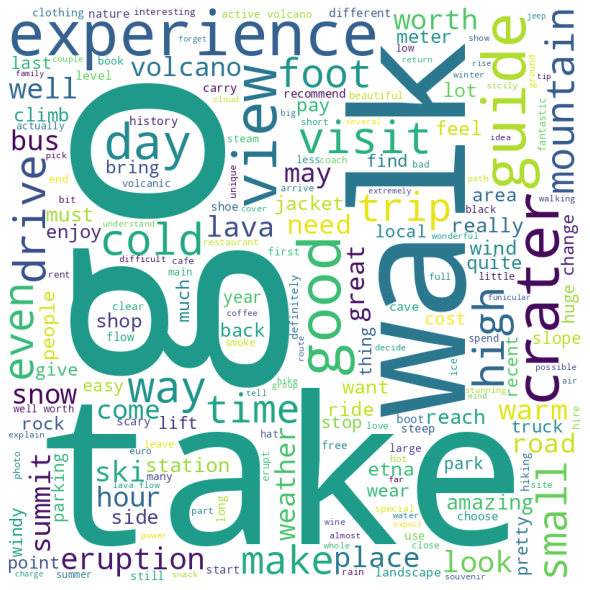

----------------------------------


Wordcloud for Review_Topic_1
0    123
1     10
Name: Review_sentiment_rating, dtype: int64


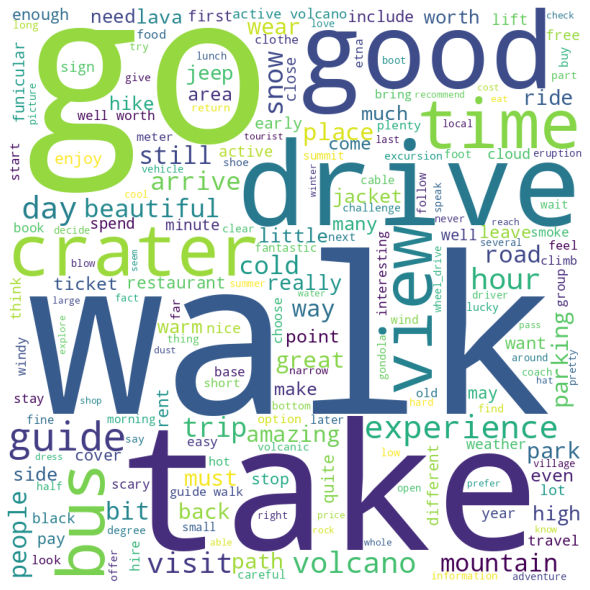

----------------------------------


Wordcloud for Review_Topic_2
0    107
1     11
Name: Review_sentiment_rating, dtype: int64


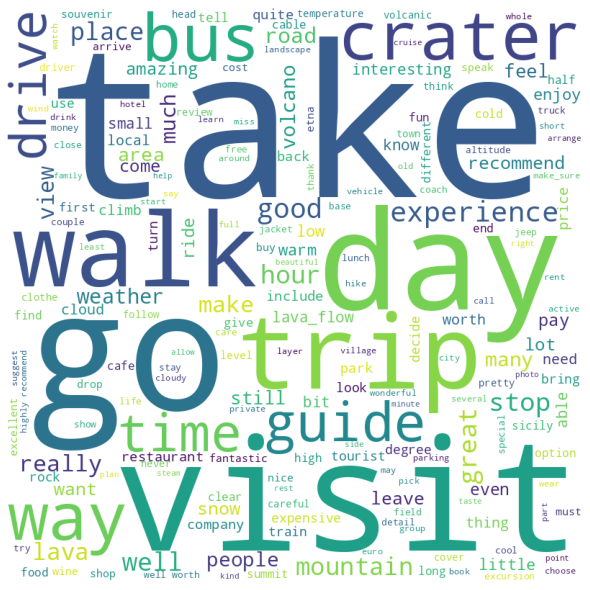

----------------------------------




In [45]:
for i in lda_review_data_tuned.filter(regex='Review_Topic_'):
    print('Wordcloud for {}'.format(i))
    review_topic = lda_review_data_tuned[lda_review_data_tuned['Review_Dominant_Topic']== i[len('Review_'):]]
    print(review_topic['Review_sentiment_rating'].value_counts())
    # WORDCLOUD
    plot_model(lda_review_tuned, plot='wordcloud', topic_num=i[len('Review_'):].replace('_', ' '), 
           #save=True
          )
    # BIGRAMS
    plot_model(lda_review_tuned, plot='bigram', topic_num=i[len('Review_'):].replace('_', ' '))
    # TRIGRAMS
    plot_model(lda_review_tuned, plot='trigram', topic_num=i[len('Review_'):].replace('_', ' '))
    
    print('----------------------------------')
    print('\n')

## Wordclouds, bigrams and trigrams for Reviews - SENTIMENT POSITIVE

Wordcloud for Review_Topic_0
0    99
Name: Review_sentiment_rating, dtype: int64


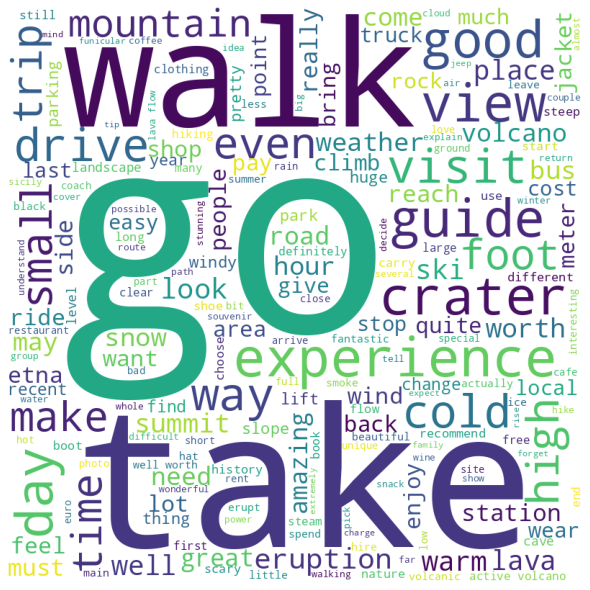

----------------------------------


Wordcloud for Review_Topic_1
0    123
Name: Review_sentiment_rating, dtype: int64


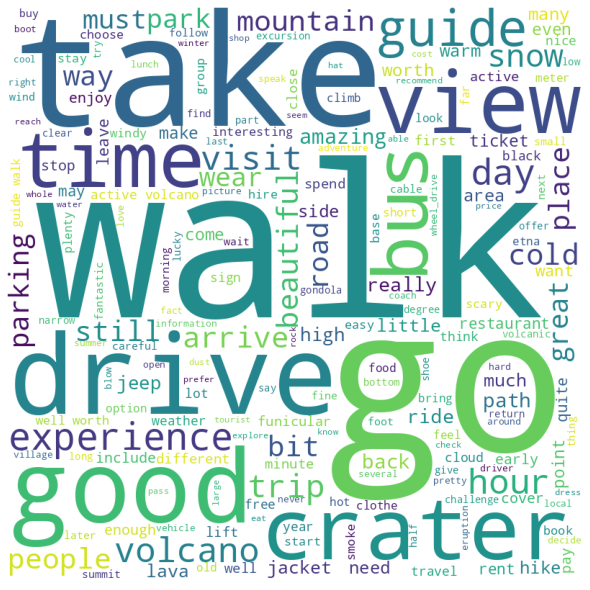

----------------------------------


Wordcloud for Review_Topic_2
0    107
Name: Review_sentiment_rating, dtype: int64


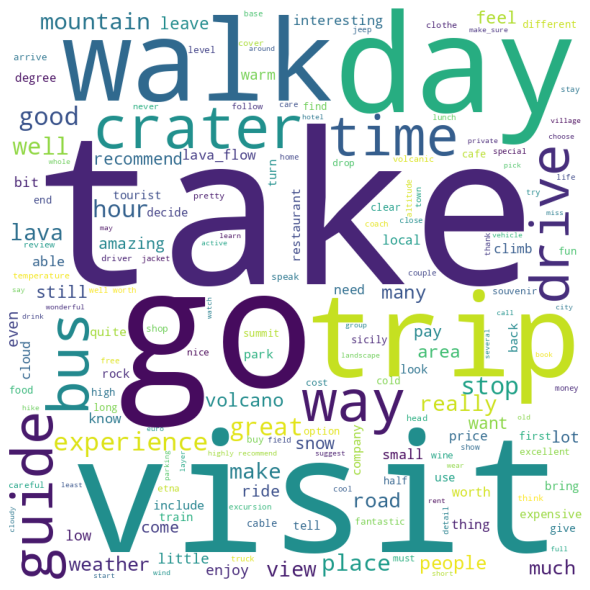

----------------------------------




In [46]:
for i in lda_review_data_tuned.filter(regex='Review_Topic_'):
    print('Wordcloud for {}'.format(i))
    review_topic = lda_review_data_tuned[lda_review_data_tuned['Review_sentiment_rating']== 0]
    review_topic = review_topic[review_topic['Review_Dominant_Topic']== i[len('Review_'):]]
    print(review_topic['Review_sentiment_rating'].value_counts())
    # WORDCLOUD
    plot_model(lda_review_tuned, plot='wordcloud', topic_num=i[len('Review_'):].replace('_', ' '), 
           #save=True
          )
    # BIGRAMS
    plot_model(lda_review_tuned, plot='bigram', topic_num=i[len('Review_'):].replace('_', ' '))
    # TRIGRAMS
    plot_model(lda_review_tuned, plot='trigram', topic_num=i[len('Review_'):].replace('_', ' '))
    
    print('----------------------------------')
    print('\n')

## Wordclouds, bigrams and trigrams for Reviews - SENTIMENT NEGATIVE

Wordcloud for Review_Topic_0
1    3
Name: Review_sentiment_rating, dtype: int64


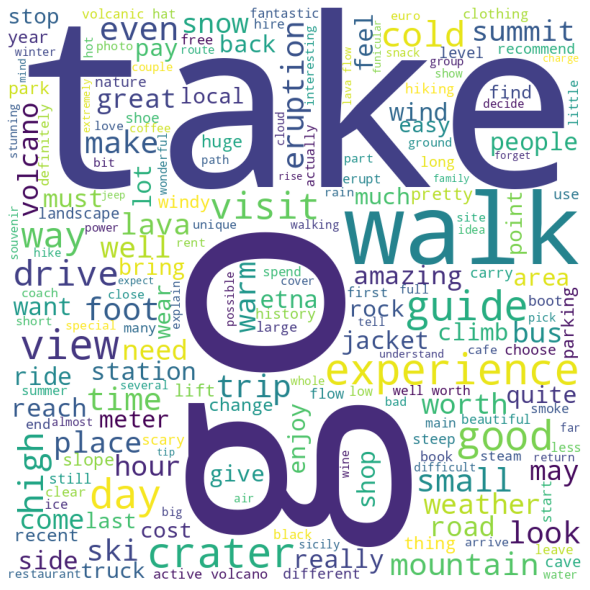

----------------------------------


Wordcloud for Review_Topic_1
1    10
Name: Review_sentiment_rating, dtype: int64


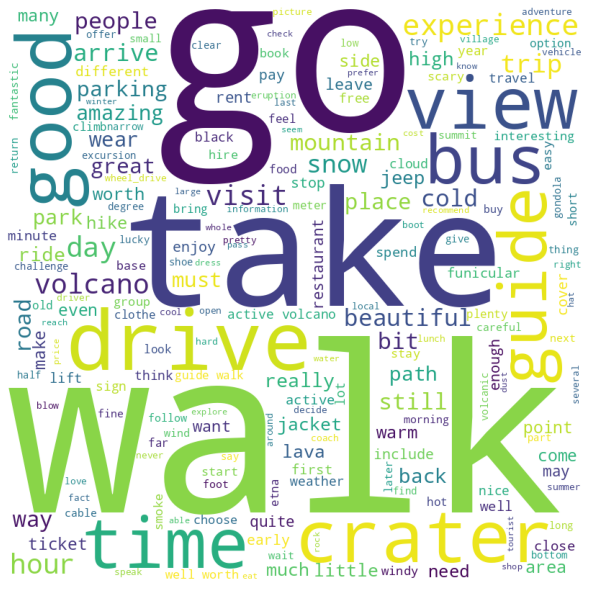

----------------------------------


Wordcloud for Review_Topic_2
1    11
Name: Review_sentiment_rating, dtype: int64


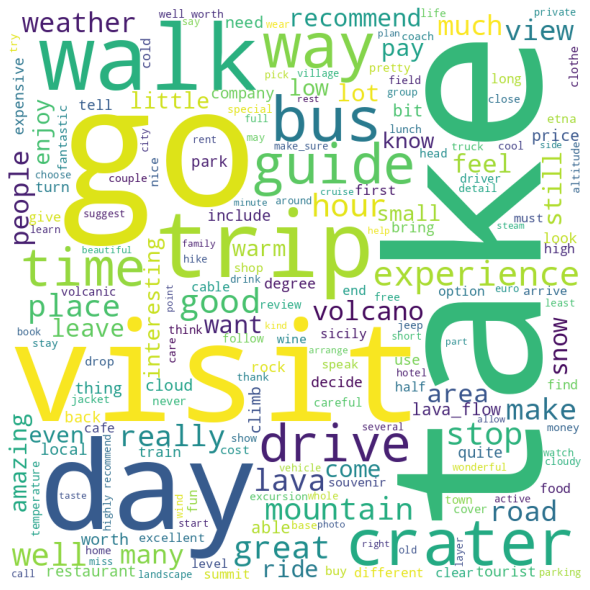

----------------------------------




In [47]:
for i in lda_review_data_tuned.filter(regex='Review_Topic_'):
    print('Wordcloud for {}'.format(i))
    review_topic = lda_review_data_tuned[lda_review_data_tuned['Review_sentiment_rating']== 1]
    review_topic = review_topic[review_topic['Review_Dominant_Topic']== i[len('Review_'):]]
    print(review_topic['Review_sentiment_rating'].value_counts())
    # WORDCLOUD
    plot_model(lda_review_tuned, plot='wordcloud', topic_num=i[len('Review_'):].replace('_', ' '), 
           #save=True
          )
    # BIGRAMS
    plot_model(lda_review_tuned, plot='bigram', topic_num=i[len('Review_'):].replace('_', ' '))
    # TRIGRAMS
    plot_model(lda_review_tuned, plot='trigram', topic_num=i[len('Review_'):].replace('_', ' '))
    
    print('----------------------------------')
    print('\n')

## Evaluation of the model

In [48]:
# Evaluation of the model
evaluate_model(lda_review_tuned)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Frequency Plot', 'freque…

In [49]:
lda_review_data_tuned

Review_content  \
0    extraordinary active volcano beautiful landsca...   
1    second visit immediately contact sabastiano li...   
2    cable ride catch terrain vehicle know price wa...   
3    life provide group special day touring freedom...   
4    drive early park big lot front restaurant stai...   
..                                                 ...   
348  join guide trip include stop fabulous experien...   
349  fly travel rent week etna beautiful right park...   
350  book trip erupt still go great time read take ...   
351  expect snow refuge bitterly cold work wind cou...   
352  go wheel_drive company guide family party quit...   

     Review_sentiment_rating  Review_Topic_0  Review_Topic_1  Review_Topic_2  \
0                          0        0.006787        0.006894        0.986318   
1                          0        0.005327        0.005437        0.989237   
2                          0        0.012921        0.081237        0.905842   
3                          0        0.001855        0.996142        0.002003   
4                          0        0.004073        0.991801        0.004126   
..                       ...             ...             ...             ...   
348                        0        0.013476        0.013736        0.972789   
349                        0        0.011341        0.978196        0.010462   
350                        0        0.097566        0.007785        0.894649   
351                        0        0.344785        0.644634        0.010582   
352                        0        0.510426        0.059189        0.430385   

    Review_Dominant_Topic  Review_Perc_Dominant_Topic  
0                 Topic_2                        0.99  
1                 Topic_2                        0.99  
2                 Topic_2                        0.91  
3                 Topic_1                        1.00  
4                 Topic_1                        0.99  
..                    ...                         ...  
348               Topic_2                        0.97  
349               Topic_1                        0.98  
350               Topic_2                        0.89  
351               Topic_1                        0.64  
352               Topic_0                        0.51  

[353 rows x 7 columns]

In [50]:
lda_review_data_tuned.to_csv(base_dir + 'data/car/lda_review_data_tuned.csv', index=False)

In [51]:
save_model(lda_review_tuned, base_dir + 'models/car/model_review_jupyter')

Model Succesfully Saved


(<gensim.models.ldamulticore.LdaMulticore at 0x7fb5fedd49d0>,
 '/mnt/g/My Drive/Academy/+ Papers/en_proceso/mount_etna/models/car/model_review_jupyter.pkl')

In [52]:
lda_review_data_tuned

Review_content  \
0    extraordinary active volcano beautiful landsca...   
1    second visit immediately contact sabastiano li...   
2    cable ride catch terrain vehicle know price wa...   
3    life provide group special day touring freedom...   
4    drive early park big lot front restaurant stai...   
..                                                 ...   
348  join guide trip include stop fabulous experien...   
349  fly travel rent week etna beautiful right park...   
350  book trip erupt still go great time read take ...   
351  expect snow refuge bitterly cold work wind cou...   
352  go wheel_drive company guide family party quit...   

     Review_sentiment_rating  Review_Topic_0  Review_Topic_1  Review_Topic_2  \
0                          0        0.006787        0.006894        0.986318   
1                          0        0.005327        0.005437        0.989237   
2                          0        0.012921        0.081237        0.905842   
3                          0        0.001855        0.996142        0.002003   
4                          0        0.004073        0.991801        0.004126   
..                       ...             ...             ...             ...   
348                        0        0.013476        0.013736        0.972789   
349                        0        0.011341        0.978196        0.010462   
350                        0        0.097566        0.007785        0.894649   
351                        0        0.344785        0.644634        0.010582   
352                        0        0.510426        0.059189        0.430385   

    Review_Dominant_Topic  Review_Perc_Dominant_Topic  
0                 Topic_2                        0.99  
1                 Topic_2                        0.99  
2                 Topic_2                        0.91  
3                 Topic_1                        1.00  
4                 Topic_1                        0.99  
..                    ...                         ...  
348               Topic_2                        0.97  
349               Topic_1                        0.98  
350               Topic_2                        0.89  
351               Topic_1                        0.64  
352               Topic_0                        0.51  

[353 rows x 7 columns]